### Image Segmentation

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
dataset_path = '/kaggle/input/dog-segmentation/Dog Segmentation' 
image_dir = os.path.join(dataset_path, 'Images')
mask_dir = os.path.join(dataset_path, 'Labels')

# Check if directories exist
if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
    raise FileNotFoundError("Image or mask directory not found. Please check the dataset structure.")

In [3]:
# Load and preprocess the dataset
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        
        # Load mask
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load the dataset
IMG_SIZE = (128, 128)
X, y = load_data(image_dir, mask_dir, IMG_SIZE)
print(f"Loaded {X.shape[0]} images and masks")

Loaded 180 images and masks


In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 144 samples
Test set: 36 samples


In [5]:
# Define the U-Net model
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    # Encoder (contracting path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (expansive path)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [6]:
# Build and compile the model
model = build_unet(input_shape=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=20,
    verbose=1
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6135 - loss: 0.6845 - val_accuracy: 0.5656 - val_loss: 0.6822
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6188 - loss: 0.6630 - val_accuracy: 0.5656 - val_loss: 0.6896
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6211 - loss: 0.6588 - val_accuracy: 0.5656 - val_loss: 0.6860
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6252 - loss: 0.6516 - val_accuracy: 0.5656 - val_loss: 0.6802
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6037 - loss: 0.6581 - val_accuracy: 0.5656 - val_loss: 0.6724
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6109 - loss: 0.6300 - val_accuracy: 0.5803 - val_loss: 0.6050
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.6748 - loss: 0.5827 - val_accuracy: 0.6064 - val_loss: 0.6137
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.7141 - loss: 0.5586 - val_accuracy: 0.7347 - val_loss: 0

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7850 - loss: 0.4401
Test Loss: 0.4387
Test Accuracy: 0.7854


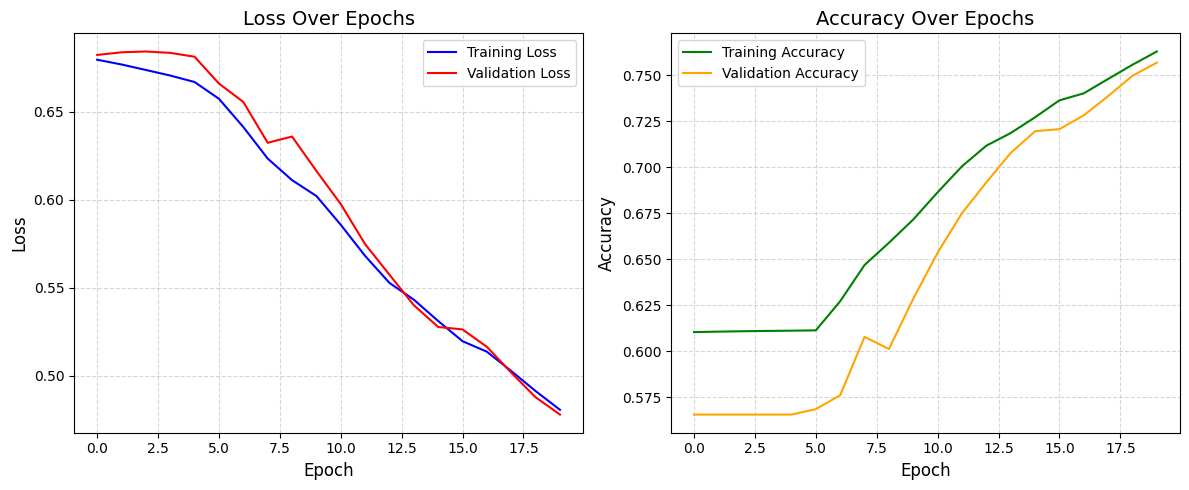

In [10]:
import seaborn as sns

# Smooth function for better visualization
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['loss']), label='Training Loss', color='blue')
plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', color='red')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy', color='green')
plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


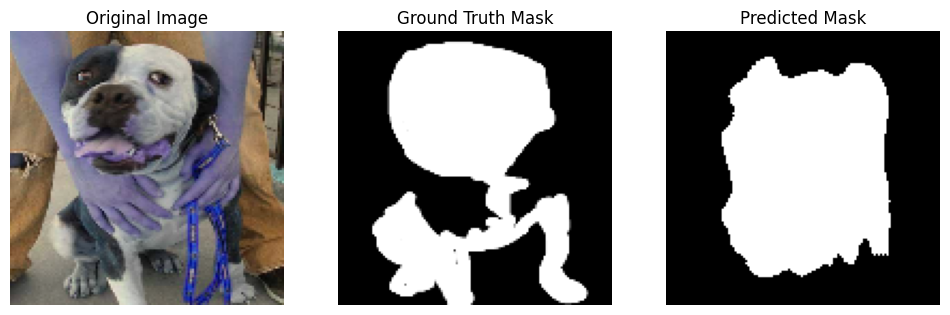

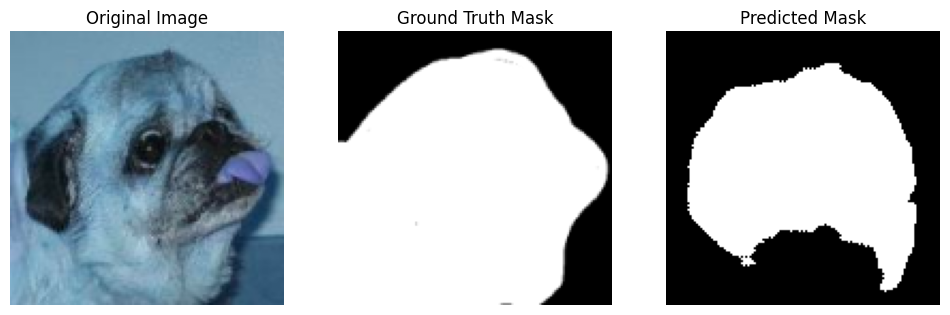

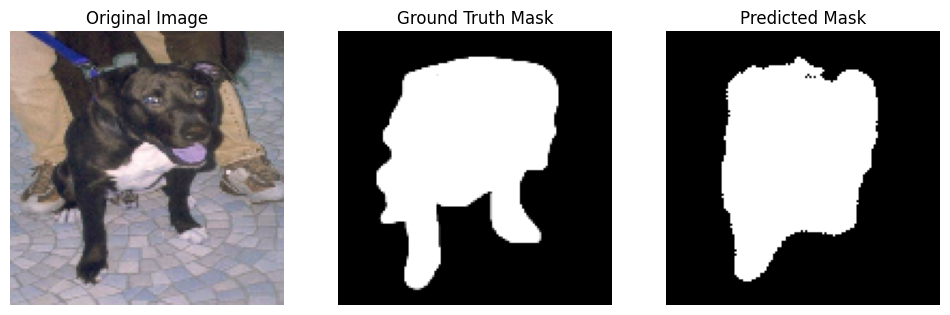

In [11]:
# Visualize predictions
def plot_predictions(X, y_true, y_pred, num_samples=3):
    indices = np.random.randint(0, X.shape[0], num_samples)
    for i, idx in enumerate(indices):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X[idx])
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(y_true[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.show()

# Predict on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Threshold predictions

# Plot some predictions
plot_predictions(X_test, y_test, y_pred, num_samples=3)

### Improved code for image segmentation

In [37]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
# Load the dataset
dataset_path = '/kaggle/input/dog-segmentation/Dog Segmentation'
image_dir = os.path.join(dataset_path, 'Images')
mask_dir = os.path.join(dataset_path, 'Labels')

In [40]:
# Check if directories exist
if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
    raise FileNotFoundError("Image or mask directory not found. Please check the dataset structure.")

In [41]:
# Load and preprocess the dataset
def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        
        # Load mask
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)


In [42]:
# Load the dataset
IMG_SIZE = (128, 128)
X, y = load_data(image_dir, mask_dir, IMG_SIZE)
print(f"Loaded {X.shape[0]} images and masks")

Loaded 180 images and masks


In [43]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 144 samples
Test set: 36 samples


In [44]:
# Data Augmentation
data_gen_args = dict(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [45]:
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit generators on the training data
image_datagen.fit(X_train)
mask_datagen.fit(y_train)

In [46]:
# Define the U-Net model
def build_unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    # Encoder (contracting path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder (expansive path)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [47]:
# Build and compile the model
model = build_unet(input_shape=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Define a custom generator that combines both image and mask batches
def image_mask_generator(image_generator, mask_generator):
    while True:
        # Get the next batch of images and masks
        img_batch = next(image_generator)
        mask_batch = next(mask_generator)
        yield img_batch, mask_batch

# Define the image and mask augmentation generators
image_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply the augmentation generators on the training set
train_image_generator = image_datagen.flow(X_train, batch_size=16, seed=42)
train_mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)

# Create the custom generator
train_generator = image_mask_generator(train_image_generator, train_mask_generator)

# Train the model with augmented data
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 16,
    epochs=25,
    verbose=1
)


Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7177 - loss: 0.5324 - val_accuracy: 0.7784 - val_loss: 0.4740
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.7610 - loss: 0.4734 - val_accuracy: 0.7741 - val_loss: 0.4555
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7473 - loss: 0.4862 - val_accuracy: 0.7344 - val_loss: 0.4921
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7518 - loss: 0.4592 - val_accuracy: 0.7675 - val_loss: 0.4568
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7652 - loss: 0.4377 - val_accuracy: 0.7881 - val_loss: 0.4360
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7482 - loss: 0.4639 - val_accuracy: 0.7896 - val_loss: 0.4195
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7693 - loss: 0.4322 - val_accuracy: 0.7836 - val_loss: 0.4385
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7738 - loss: 0.4245 - val_accuracy: 0.7740 - val_loss:

In [58]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7913 - loss: 0.4232
Test Loss: 0.4218
Test Accuracy: 0.7924


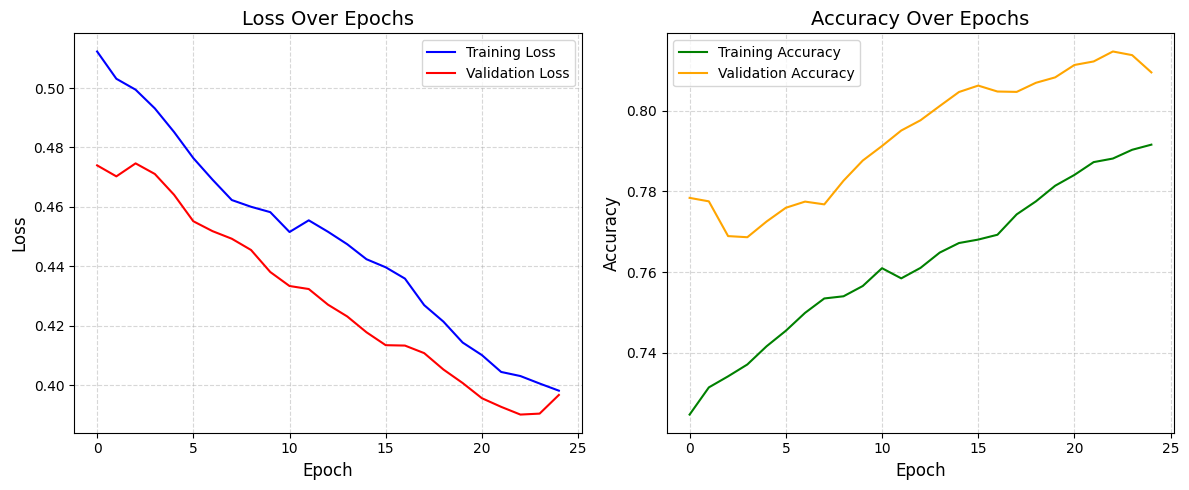

In [59]:
# Smooth function for better visualization
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['loss']), label='Training Loss', color='blue')
plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', color='red')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy', color='green')
plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [60]:
# Visualize predictions
def plot_predictions(X, y_true, y_pred, num_samples=3):
    indices = np.random.randint(0, X.shape[0], num_samples)
    for i, idx in enumerate(indices):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X[idx])
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(y_true[idx].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


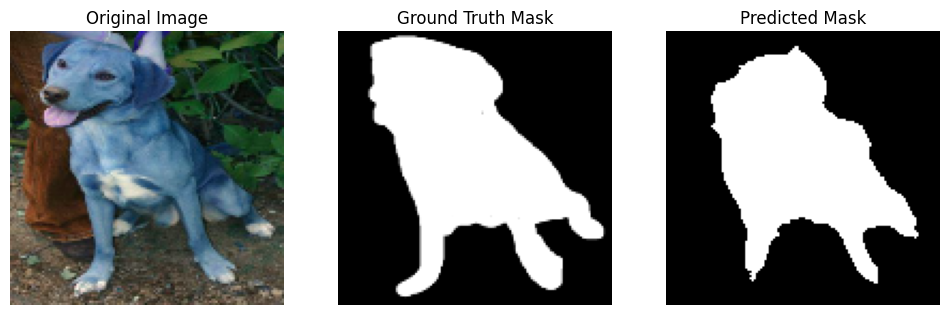

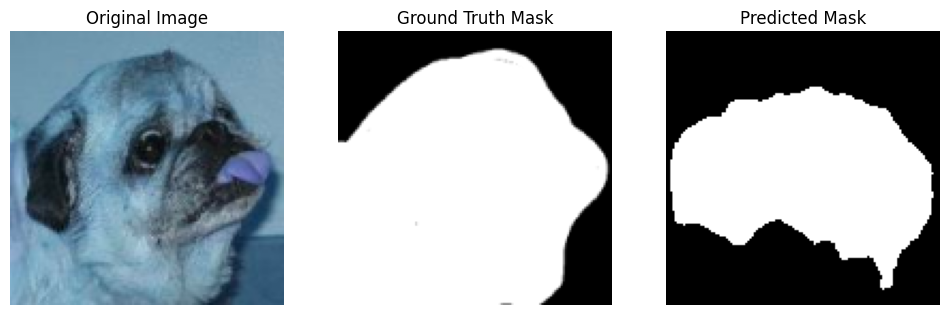

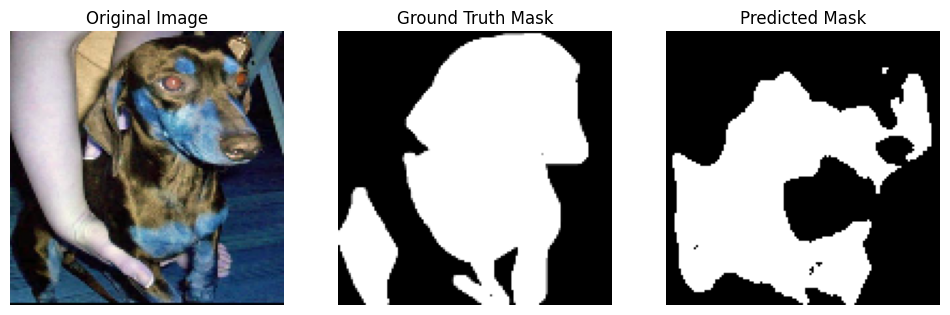

In [61]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.float32)  # Threshold predictions

# Plot some predictions
plot_predictions(X_test, y_test, y_pred, num_samples=3)